In [1]:
import numpy as np
import pandas as pd
import tweepy
import matplotlib.pyplot as plt
import pymongo
import ipywidgets as wgt
from IPython.display import display
from sklearn.feature_extraction.text import CountVectorizer
import re
from datetime import datetime

In [2]:
api_key = '3mBQlhZHYSvrS37Nt47CNuDAH'
api_secret = 'ZmGYg594O5AVABdYFRM8QkIaubVDauRfpncALnm9ilaBZL47h8'
access_token = '1065785581601345536-LLAnqdBWVk5NQ3P2TOfxv87RDn0spJ'
access_token_secret = 'MMwkQHuZNH5WoYOsAy300iPdw4f8YMuPCKRhQ7Uw0Jngg'

auth = tweepy.OAuthHandler(api_key, api_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth)
col = pymongo.MongoClient()["twitter"]["biden"]
col.count()

C:\Users\Asus\miniconda3\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: count is deprecated. Use estimated_document_count or count_documents instead. Please note that $where must be replaced by $expr, $near must be replaced by $geoWithin with $center, and $nearSphere must be replaced by $geoWithin with $centerSphere
  # This is added back by InteractiveShellApp.init_path()


0

In [3]:
class MyStreamListener(tweepy.StreamListener):
    
    counter = 0
    
    def __init__(self, max_tweets=5000, *args, **kwargs):
        self.max_tweets = max_tweets
        self.counter = 0
        super().__init__(*args, **kwargs)
    
    def on_connect(self):
        self.counter = 0
        self.start_time = datetime.now()
    
    def on_status(self, status):
        # Increment counter
        self.counter += 1
        
        # Store tweet to MongoDB
        col.insert_one(status._json)
        
        
        if self.counter % 1 == 0:
            value = int(100.00 * self.counter / self.max_tweets)
            mining_time = datetime.now() - self.start_time
            progress_bar.value = value
            html_value = """<span class="label label-primary">Tweets/Sec: %.1f</span>""" % (self.counter / max([1,mining_time.seconds]))
            html_value += """ <span class="label label-success">Progress: %.1f%%</span>""" % (self.counter / self.max_tweets * 100.0)
            html_value += """ <span class="label label-info">ETA: %.1f Sec</span>""" % ((self.max_tweets - self.counter) / (self.counter / max([1,mining_time.seconds])))
            wgt_status.value = html_value
            #print("%s/%s" % (self.counter, self.max_tweets))
            if self.counter >= self.max_tweets:
                myStream.disconnect()
                print("Finished")
                print("Total Mining Time: %s" % (mining_time))
                print("Tweets/Sec: %.1f" % (self.max_tweets / mining_time.seconds))
                progress_bar.value = 0
                
    
myStreamListener = MyStreamListener(max_tweets=5000)
myStream = tweepy.Stream(auth = api.auth, listener=myStreamListener)
keywords = ["Joe Biden",
            "Biden"
           ]

# Visualize a progress bar to track progress
progress_bar = wgt.IntProgress(value=0)
display(progress_bar)
wgt_status = wgt.HTML(value="""<span class="label label-primary">Tweets/Sec: 0.0</span>""")
display(wgt_status)

# Start a filter with an error counter of 20
for error_counter in range(20):
    try:
        myStream.filter(track=keywords)
        print("Tweets collected: %s" % myStream.listener.counter)
        print("Total tweets in collection: %s" % col.count())
        break
    except:
        print("ERROR# %s" % (error_counter + 1))

IntProgress(value=0)

HTML(value='<span class="label label-primary">Tweets/Sec: 0.0</span>')

Finished
Total Mining Time: 0:05:39.767444
Tweets/Sec: 14.7
Tweets collected: 5000
Total tweets in collection: 5000


C:\Users\Asus\miniconda3\lib\site-packages\ipykernel_launcher.py:56: DeprecationWarning: count is deprecated. Use estimated_document_count or count_documents instead. Please note that $where must be replaced by $expr, $near must be replaced by $geoWithin with $center, and $nearSphere must be replaced by $geoWithin with $centerSphere


In [4]:
col.find_one()

{'_id': ObjectId('5f9e7edc820f249e8509821e'),
 'created_at': 'Sun Nov 01 09:24:38 +0000 2020',
 'id': 1322831907999092736,
 'id_str': '1322831907999092736',
 'text': 'zigi gigi zayn halloween TAYLOR IS FREE taylor swift zendaya biden trump vote election covid19 covid coronavirus jo… https://t.co/jgj5X0T3sC',
 'source': '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
 'truncated': True,
 'in_reply_to_status_id': None,
 'in_reply_to_status_id_str': None,
 'in_reply_to_user_id': None,
 'in_reply_to_user_id_str': None,
 'in_reply_to_screen_name': None,
 'user': {'id': 1322734368725651463,
  'id_str': '1322734368725651463',
  'name': '🛹',
  'screen_name': 'drewthesizzler1',
  'location': None,
  'url': None,
  'description': 'reserva',
  'translator_type': 'none',
  'protected': False,
  'verified': False,
  'followers_count': 0,
  'friends_count': 3,
  'listed_count': 0,
  'favourites_count': 0,
  'statuses_count': 20,
  'created_at': 'Sun Nov 01 02:57

In [5]:
dataset = [{"created_at": item["created_at"],
            "text": item["text"],
            "user": "@%s" % item["user"]["screen_name"],
            "source": item["source"],
            "lang":item["lang"],
            
           } for item in col.find()]

dataset = pd.DataFrame(dataset)
dataset.head()

,created_at,text,user,source,lang
0,Sun Nov 01 09:24:38 +0000 2020,zigi gigi zayn halloween TAYLOR IS FREE taylor...,@drewthesizzler1,"<a href=""http://twitter.com/download/iphone"" r...",en
1,Sun Nov 01 09:24:38 +0000 2020,RT @KamVTV: ICYMI: The Biden bus tour canceled...,@Zhuxudong5,"<a href=""http://twitter.com/download/android"" ...",en
2,Sun Nov 01 09:24:38 +0000 2020,@gobusurv Ek zamana tha they use to worship Tr...,@its_jameel,"<a href=""https://mobile.twitter.com"" rel=""nofo...",en
3,Sun Nov 01 09:24:38 +0000 2020,RT @HowleyReporter: Nightmare\n\nhttps://t.co/...,@abe_american,"<a href=""https://mobile.twitter.com"" rel=""nofo...",en
4,Sun Nov 01 09:24:38 +0000 2020,RT @hermanntertsch: Todos los enemigos de la l...,@m6278467,"<a href=""http://twitter.com/download/iphone"" r...",es


In [6]:
cv = CountVectorizer()
count_matrix = cv.fit_transform(dataset.text)

word_count = pd.DataFrame(cv.get_feature_names(), columns=["word"])
word_count["count"] = count_matrix.sum(axis=0).tolist()[0]
word_count = word_count.sort_values("count", ascending=False).reset_index(drop=True)
word_count[:50]

,word,count
0,rt,3595
1,biden,3310
2,the,2473
3,https,1693
4,co,1654
5,to,1642
6,in,1449
7,and,1435
8,trump,1404
9,of,1169


C:\Users\Asus\miniconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  import sys


feather for iOS           3
Tweetbot for iΟS          5
Echofon                   6
WordPress.com             8
dlvr.it                  14
TweetDeck                18
Twitter for iPad        319
Twitter Web App        1117
Twitter for iPhone     1694
Twitter for Android    1781
Name: source, dtype: int64

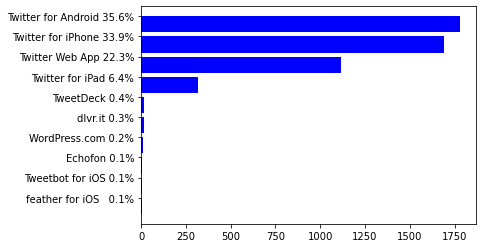

In [7]:
def get_source_name(x):
    value = re.findall(pattern="<[^>]+>([^<]+)</a>", string=x)
    if len(value) > 0:
        return value[0]
    else:
        return ""
dataset.source_name = dataset.source.apply(get_source_name)

source_counts = dataset.source_name.value_counts().sort_values()[-10:]

bottom = [index for index, item in enumerate(source_counts.index)]
plt.barh(bottom, width=source_counts, color="blue", linewidth=0)

y_labels = ["%s %.1f%%" % (item, 100.0*source_counts[item]/len(dataset)) for index,item in enumerate(source_counts.index)]
plt.yticks(np.array(bottom)+0.4, y_labels)

source_counts

zh       31
tr       31
pt       33
nl       34
it       44
de       45
es       78
fr      121
und     258
en     4222
Name: lang, dtype: int64

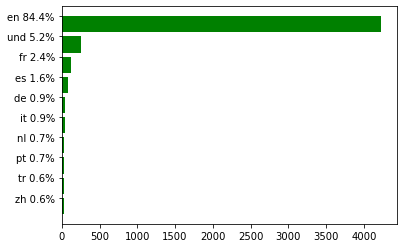

In [8]:
lang_counts = dataset.lang.value_counts().sort_values()[-10:]
bottom = [index for index, item in enumerate(lang_counts.index)]
plt.barh(bottom, width=lang_counts, color="green", linewidth=0)
y_labels = ["%s %.1f%%" % (item, 100.0*lang_counts[item]/len(dataset)) for index,item in enumerate(lang_counts.index)]
plt.yticks(np.array(bottom)+0.4, y_labels)
lang_counts

In [9]:
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt

In [10]:
dataset1 = [{"id": item["id"],
            "text": item["text"],
            "lang":item["lang"],
            
           } for item in col.find()]

dataset1 = pd.DataFrame(dataset1)
is_dataset1=dataset1.lang=="en"
dataset1=dataset1[is_dataset1]
dataset1

,id,text,lang
0,1322831907999092736,zigi gigi zayn halloween TAYLOR IS FREE taylor...,en
1,1322831908233883648,RT @KamVTV: ICYMI: The Biden bus tour canceled...,en
2,1322831908573605890,@gobusurv Ek zamana tha they use to worship Tr...,en
3,1322831908867350535,RT @HowleyReporter: Nightmare\n\nhttps://t.co/...,en
5,1322831909483814913,That warning came true all too soon with thugs...,en
...,...,...,...
4994,1322833332116295685,"RT @lizyeld: That's a great idea Biden, do awa...",en
4996,1322833332309295105,RT @RealJamesWoods: Are you kidding? They’re a...,en
4997,1322833332686647296,RT @tarheelwolfpack: Do you really want to fal...,en
4998,1322833332770582528,RT @mattmfm: Videos of this incident are all o...,en


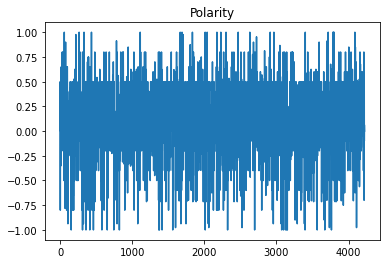

In [11]:
from  textblob import TextBlob
tweettext=dataset1['text']
wordlist=pd.DataFrame();

polarity=[]
subj=[]

for t in tweettext:
    tx= TextBlob(t)
    polarity.append(tx.sentiment.polarity)
    subj.append(tx.sentiment.subjectivity)

poltweet= pd.DataFrame({'polarity':polarity,'subjectivity':subj})
poltweet.polarity.plot(title='Polarity')
plt.show()

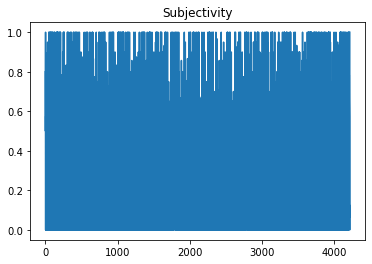

In [12]:
poltweet.subjectivity.plot(title='Subjectivity')
plt.show()

In [13]:
import statistics
statistics.mean(poltweet.polarity)

0.04909124320531401

In [14]:
import statistics
statistics.mean(poltweet.subjectivity)

0.31234057233864787

In [15]:
#Fuction to get clean text to get better analysis
def cleanText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text)
    text = re.sub(r'#', '', text)
    text = re.sub(r'RT[\s]+', '', text)
    text = re.sub(r'https?:\/\/\S+', '', text)
    
    return text

dataset1['text'] = dataset1['text'].apply(cleanText)

dataset1

,id,text,lang
0,1322831907999092736,zigi gigi zayn halloween TAYLOR IS FREE taylor...,en
1,1322831908233883648,: ICYMI: The Biden bus tour canceled the rest ...,en
2,1322831908573605890,"Ek zamana tha they use to worship Trump, now ...",en
3,1322831908867350535,: Nightmare\n\n,en
5,1322831909483814913,That warning came true all too soon with thugs...,en
...,...,...,...
4994,1322833332116295685,": That's a great idea Biden, do away with oil ...",en
4996,1322833332309295105,: Are you kidding? They’re all breathing the s...,en
4997,1322833332686647296,: Do you really want to fall victim to the lar...,en
4998,1322833332770582528,: Videos of this incident are all over Twitter...,en


In [16]:
#Fuction to get subjectivity and polarity
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
    return TextBlob(text).sentiment.polarity

dataset1['Subjectivity'] = dataset1['text'].apply(getSubjectivity)
dataset1['Polarity'] = dataset1['text'].apply(getPolarity)

dataset1

,id,text,lang,Subjectivity,Polarity
0,1322831907999092736,zigi gigi zayn halloween TAYLOR IS FREE taylor...,en,0.8000,0.4000
1,1322831908233883648,: ICYMI: The Biden bus tour canceled the rest ...,en,0.5000,0.5000
2,1322831908573605890,"Ek zamana tha they use to worship Trump, now ...",en,1.0000,-0.8000
3,1322831908867350535,: Nightmare\n\n,en,0.0000,0.0000
5,1322831909483814913,That warning came true all too soon with thugs...,en,0.5750,0.4250
...,...,...,...,...,...
4994,1322833332116295685,": That's a great idea Biden, do away with oil ...",en,0.5750,0.5000
4996,1322833332309295105,: Are you kidding? They’re all breathing the s...,en,0.0625,-0.1000
4997,1322833332686647296,: Do you really want to fall victim to the lar...,en,0.1250,0.0625
4998,1322833332770582528,: Videos of this incident are all over Twitter...,en,0.0000,0.0000


In [17]:
#Function to compute positive negative neutral analysis
def getAnalysis(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'
    
dataset1['Analysis'] = dataset1['Polarity'].apply(getAnalysis)

dataset1

,id,text,lang,Subjectivity,Polarity,Analysis
0,1322831907999092736,zigi gigi zayn halloween TAYLOR IS FREE taylor...,en,0.8000,0.4000,Positive
1,1322831908233883648,: ICYMI: The Biden bus tour canceled the rest ...,en,0.5000,0.5000,Positive
2,1322831908573605890,"Ek zamana tha they use to worship Trump, now ...",en,1.0000,-0.8000,Negative
3,1322831908867350535,: Nightmare\n\n,en,0.0000,0.0000,Neutral
5,1322831909483814913,That warning came true all too soon with thugs...,en,0.5750,0.4250,Positive
...,...,...,...,...,...,...
4994,1322833332116295685,": That's a great idea Biden, do away with oil ...",en,0.5750,0.5000,Positive
4996,1322833332309295105,: Are you kidding? They’re all breathing the s...,en,0.0625,-0.1000,Negative
4997,1322833332686647296,: Do you really want to fall victim to the lar...,en,0.1250,0.0625,Positive
4998,1322833332770582528,: Videos of this incident are all over Twitter...,en,0.0000,0.0000,Neutral


In [18]:
#percentage of positive
ptweets = dataset1[dataset1.Analysis == 'Positive']
ptweets = ptweets['text']

round( (ptweets.shape[0] / dataset1.shape[0]) *100,1)

33.7

In [19]:
#percentage of negative
ntweets = dataset1[dataset1.Analysis == 'Negative']
ntweets = ntweets['text']

round( (ntweets.shape[0] / dataset1.shape[0]) *100,1)

21.9

In [20]:
#percentage of neutral
neutweets = dataset1[dataset1.Analysis == 'Neutral']
neutweets = neutweets['text']

round( (neutweets.shape[0] / dataset1.shape[0]) *100,1)

44.4

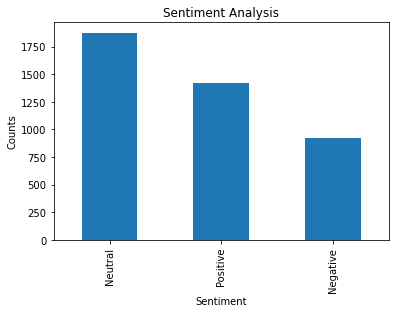

In [21]:
dataset1['Analysis'].value_counts()

plt.title('Sentiment Analysis')
plt.xlabel('Sentiment')
plt.ylabel('Counts')
dataset1['Analysis'].value_counts().plot(kind='bar')
plt.show()